### Dredging task: 
- 9 million m3 sediment

### Distance between loading and unloading sites:
- 10 km

### Water depth: 
- 18 m

### TSHD: 
- Hopper 30000 m3;
- LBT 190 * 36 * 14m;
- total installed power 37060 kW; 
- pump power trailing 2 * 4500 kW; 
- pump power discharging 16000 kW

### Cost estimation based on course & online resoures
- vessel rent cost: 20000 USD/hour
- fuel cost: 600 USD/ton
- carbon cost: 27 USD/ton


#### Practical strategies for ships passing limited water depth to achieve multiple goals
- Strategies include vessel sailing velocities, payload adjustment(actual draught), parcial engine load
- multiple goals covers the indicators of fuel use, emissions (CO2, PM10, NOx), transport time, safefy (represented by the remaining space between ship bottom and the bed of the waterway). 

##### Steps
- present a waterway section (10 km with 18 m water depth) on the graph
- provide a list of feasible draughts according to vessel size, water depth and safety margin (minimum ukc) prevent grounding
- use get_v funtion to get maximum feasible velocity considering both installed enegine power and ship squat while moving at a speed
- for each possible T&V combination, incorporate energy module, output a table with results of all the indicators
- use 'Parallel coordinate plot' to visualise strategies
- Automatically select optimal strategies to achieve the goal of less transport time, less emissions, less fuel use, safety guarantees.

In [1]:

# spatial libraries
import shapely.geometry
import pyproj

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt
import requests
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

import functools
import itertools
import warnings
warnings.filterwarnings('ignore')
import sys
sys.tracebacklimit=0
# package(s) related to time, space and id
import logging
import datetime, time
import platform

# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling

import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import tqdm

# Used for mathematical functions
import math             

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
#logging.basicConfig(level=logging.INFO)# turn off all the debug messages

logger = logging.getLogger('notebook')

# Used for making the graph
import networkx as nx

# OpenTNSim
import opentnsim


#### Present the waterway section with limited water depth on the graph network

In [2]:
# 10 km between load and unload sites
coords = [
    [0,0],
    [0.08983,0]] 


# these are the indices of the points above
edge_indices = [
    [0, 1]
]

depths = [18] 

widths = [300]

points = [
    shapely.geometry.Point(*coord )
    for coord 
    in coords
]

In [3]:
# define Site class
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

In [4]:
FG = nx.DiGraph()

nodes = []
for index, coord in enumerate(coords):
    data_node = {"name": str(index), "geometry": shapely.geometry.Point(points[index].x, points[index].y)}
    nodes.append(Node(**data_node))

for node in nodes:
    FG.add_node(node.name, geometry = node.geometry)    
    
for index, edge in enumerate(edge_indices):
    edge_geometry = shapely.geometry.LineString([points[edge[0]], points[edge[1]]])
    edge_properties = dict(
        GeneralDepth = depths[index],
        width = widths[index],
        geometry = edge_geometry, 
        length = round(edge_geometry.length),
        e = tuple(edge)
    )
    FG.add_edge( str(edge[0]), str(edge[1]), weight = 1, Info = edge_properties)

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

In [5]:
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)

In [6]:
# collect node labels.
labels = {}
for node in FG.nodes:
    labels[node] = node

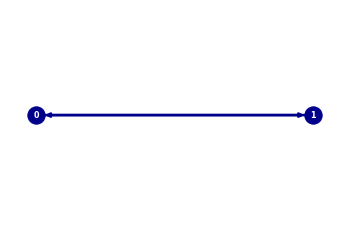

In [7]:
# draw edges, nodes and labels.
colors =['darkblue']
nx.draw_networkx_edges(FG,  pos=positions, width=2.5, edge_color=colors, alpha=1, arrowsize=8)
nx.draw_networkx_nodes(FG,  pos=positions, node_color="darkblue", node_size=300)
nx.draw_networkx_labels(FG, pos=positions, labels=labels, font_size=8, font_weight='bold', font_color="white")

plt.axis("off")
plt.savefig('graph_dredging.pdf', bbox_inches = 'tight', dpi=600, format='pdf') 
plt.show()

#### Create vessel - add VesselProperties and ConsumesEnergy mixins

In [8]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.Routeable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [9]:
# Create a dict with all important settings
data_vessel = {
               "env": None,
               "name": None,
               "route": None,
               "geometry": None,
               "v": None,  # m/s
               "type":  None, # <-- note that inputs from hereon are due to the added mixins!
               "B": 36.2,
               "L": 190,
               "H_e": None, 
               "H_f": None, 
               "T": 14,
               "safety_margin": 0.2, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
               "h_squat":True,
               "P_installed": 37060, # kW  
               "P_tot_given": None, # kW
               "bulbous_bow": False, # if a vessel has no bulbous_bow, set to none; otherwise set to 1.
               "P_hotel_perc": 0.05,
               "P_hotel": None, # None: calculate P_hotel from percentage
               "x": 2,# number of propellers
               "L_w": 3.0 ,
               "C_B":0.85, 
               "C_year":2000,
              }        
data_vessel_i = data_vessel.copy()
vessel = TransportResource(**data_vessel_i)

#### Provide a group of feasible draughts according to vessel size, water depth and safety margin (minimum ukc) prevent grounding
here we choose M8 vessel as it has a large share of the sailing movements per year on waal (Rijkswaterstaat,2021, Safety aspects of new energy carriers in inland navigation), M8's draught ranges from 1.4 m to 3.5 m, considering a safety margin (minimum ukc) of 0.2 m at water depth 2.5 m, the final feasible draught ranges from 1.4 m to 2.3 m.

In [10]:
# provide max and min draught
max_draught = 14
min_operational_draught = 6
stepsize = -1

# create lists of strategy values
T_strategy = np.arange(max_draught, round(min_operational_draught + stepsize, 2), stepsize).round(2).tolist()
h_min = [18]
safety_margin = [0.2]
width = [300]


In [11]:
# prepare the work to be done by creating a list of all combinations
work = list(itertools.product(T_strategy, h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"T_strategy": item[0],"h_min":item[1], "safety_margin":item[2], "width":item[3]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.head(20)

,T_strategy,h_min,safety_margin,width
0,14,18,0.2,300
1,13,18,0.2,300
2,12,18,0.2,300
3,11,18,0.2,300
4,10,18,0.2,300
5,9,18,0.2,300
6,8,18,0.2,300
7,7,18,0.2,300
8,6,18,0.2,300


#### Caculate the maximum velocity the vessel can sail at for each T_strategy, considering maximum sinkage and installed engine power

In [12]:
Strategies = []

for i, row in tqdm.tqdm(work_df.iterrows(),disable=True):

    # get vessel 
    data_vessel_i = data_vessel.copy()
    vessel = TransportResource(**data_vessel_i)
    vessel._T = row['T_strategy']
    vessel.safety_margin = row['safety_margin']
    
    # estimate 'grounding speed' as a useful upperbound
    upperbound, selected, results_df = opentnsim.strategy.get_upperbound_for_power2v(vessel, width=row['width'], depth=row['h_min'], margin=0)
    
    # calculate the velocity that belongs to the T_strategy (while leaving the margin)
    v, depth, depth_squat, z_computed, margin = opentnsim.strategy.get_v(vessel, width=row['width'], depth=row['h_min'], margin=row['safety_margin'], bounds=(0, upperbound))
    
    # detaremine payload
    Payload_comupted = opentnsim.strategy.T2Payload(vessel, row['T_strategy'], vessel_type = "Tanker") 
    
    Strategy ={}
    Strategy.update(row)
    Strategy['v_upper_bound (m/s)'] = upperbound # power allowed max v   
    Strategy['v_strategy (m/s)'] = v  # final max v considering squat and installed power
    Strategy['z_computed (m)'] = z_computed
    Strategy['depth squat (m)'] = depth_squat
    Strategy['T + margin (m)'] = row['T_strategy']+ row['safety_margin']
    
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted
    Strategies.append(Strategy)

In [13]:
Strategies_df = pd.DataFrame(Strategies)
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(Strategies_df)

,T_strategy,h_min,safety_margin,width,v_upper_bound (m/s),v_strategy (m/s),z_computed (m),depth squat (m),T + margin (m),Payload_strategy_tanker (ton)
0,14.00,18.00,0.20,300.00,8.73,8.73,2.25,15.75,14.20,53805.19
1,13.00,18.00,0.20,300.00,8.93,8.93,2.22,15.78,13.20,53805.19
2,12.00,18.00,0.20,300.00,9.01,9.01,2.12,15.88,12.20,53805.19
3,11.00,18.00,0.20,300.00,9.03,9.03,1.99,16.01,11.20,53805.19
4,10.00,18.00,0.20,300.00,9.07,9.07,1.85,16.15,10.20,53805.19
5,9.00,18.00,0.20,300.00,9.10,9.10,1.71,16.29,9.20,53805.19
6,8.00,18.00,0.20,300.00,9.10,9.10,1.56,16.44,8.20,52628.04
7,7.00,18.00,0.20,300.00,9.30,9.30,1.46,16.54,7.20,45412.78
8,6.00,18.00,0.20,300.00,9.30,9.30,1.29,16.71,6.20,38458.20


#### Provide a group of feasible velocities for each T_strategy

In [14]:
# provide max and min draught
v_feasible_forT = []
for row in Strategies:
    max_velocity = row['v_strategy (m/s)']
    min_velocity = 3
    stepsize = -1
    # create lists of strategy values
    v_feasible = np.arange(max_velocity, round(min_velocity + stepsize, 2), stepsize).round(2).tolist()
    v_feasible_forT.append(v_feasible)
v_df = pd.DataFrame(v_feasible_forT).T
names=['T=14','T=13','T=12','T=11','T=10','T=9','T=8','T=7','T=6']
v_df.columns=names
v_df

,T=14,T=13,T=12,T=11,T=10,T=9,T=8,T=7,T=6
0,8.73,8.93,9.01,9.03,9.07,9.1,9.1,9.3,9.3
1,7.73,7.93,8.01,8.03,8.07,8.1,8.1,8.3,8.3
2,6.73,6.93,7.01,7.03,7.07,7.1,7.1,7.3,7.3
3,5.73,5.93,6.01,6.03,6.07,6.1,6.1,6.3,6.3
4,4.73,4.93,5.01,5.03,5.07,5.1,5.1,5.3,5.3
5,3.73,3.93,4.01,4.03,4.07,4.1,4.1,4.3,4.3
6,2.73,2.93,3.01,3.03,3.07,3.1,3.1,3.3,3.3
7,NaN,NaN,2.01,2.03,2.07,2.1,2.1,2.3,2.3


In [15]:
# create a new table of all the v/strategy combinations
# using the itertools.product is more pro
# but for now we'll just loop
rows = []
for strategy in Strategies:
    max_velocity = strategy['v_strategy (m/s)']
    min_velocity = 1
    stepsize = -0.1
    v_feasible = np.arange(max_velocity, round(min_velocity + stepsize, 2), stepsize).round(2)
    for v_feasible_i in v_feasible:
        row = {}
        row.update(strategy)
        row['max_velocity'] = max_velocity
        row['min_velocity'] = min_velocity
        row['stepsize'] = stepsize
        row['v_feasible'] = v_feasible_i
       
        rows.append(row)
v_flat_df = pd.DataFrame(rows)        

    

In [16]:
columns = ['T_strategy', 'v_feasible', 'h_min', 'safety_margin', 'width']
# select relevant info
# these are all the runs that we want to run a simulation 
runs_df = v_flat_df[columns]
runs_df

,T_strategy,v_feasible,h_min,safety_margin,width
0,14.0,8.73,18.0,0.2,300.0
1,14.0,8.63,18.0,0.2,300.0
2,14.0,8.53,18.0,0.2,300.0
3,14.0,8.43,18.0,0.2,300.0
4,14.0,8.33,18.0,0.2,300.0
...,...,...,...,...,...
733,6.0,1.40,18.0,0.2,300.0
734,6.0,1.30,18.0,0.2,300.0
735,6.0,1.20,18.0,0.2,300.0
736,6.0,1.10,18.0,0.2,300.0


In [17]:
# import IPython.display

# T_strategies = v_flat_df.T_strategy.unique()

# def get_v_feasible_for_T(T_strategy):
#     selected_df = v_flat_df[np.isclose(v_flat_df.T_strategy, T_strategy)]
#     columns = ['T_strategy', 'v_feasible', 'h_min', 'safety_margin', 'width']
#     return selected_df[columns]

# runs = []
# for T_strategy in T_strategies:
#     v_feasible_df = get_v_feasible_for_T(T_strategy)
#     runs.append(v_feasible_df)




In [18]:
T_strategy = pd.DataFrame(T_strategy).T 
T_names=['T=14','T=13','T=12','T=11','T=10','T=9','T=8','T=7','T=6']
T_strategy.columns = T_names
T_strategy

,T=14,T=13,T=12,T=11,T=10,T=9,T=8,T=7,T=6
0,14,13,12,11,10,9,8,7,6


In [19]:
v_df.T
v_df
max_velocity

9.298275126029447

#### for each possible T&V combination, incorporate energy module, output a table with results of all the indicators
 indicators: fuel use, emissions (CO2, PM10, NOx), transport time, safefy (represented by the remaining space between ship bottom and the bed of the waterway)

In [20]:
def run_simulation(V_s, T):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    data_vessel_i = data_vessel.copy()
    vessel = TransportResource(**data_vessel_i)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.v = V_s
    vessel._T = T
    # vessel.P_tot_given = P_tot_given    

    # Start the simulation
    env.process(vessel.move())
    env.run()

    return vessel

In [21]:
path = nx.dijkstra_path(FG, nodes[0].name, nodes[1].name)

In [22]:
results = []
import time
def run_and_postprocess(row, vessel):
    max_sinkage = (vessel.C_B * ((vessel.B * row['T_strategy']) / (row['width'] * row['h_min'])) ** 0.81) * (
        (row['v_feasible']*1.94) ** 2.08) / 20
    Payload_comupted = opentnsim.strategy.T2Payload(vessel, row['T_strategy'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel = run_simulation(V_s = row['v_feasible'],T = row['T_strategy'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    result = {}
    result.update(row)
    result['transport time (s)'] = energycalculation.energy_use["distance"][0]/row['v_feasible']
    # result['transport time (s)'] = 10000*500 /row['v_feasible']
    result['Fuel Use (g)'] = energycalculation.energy_use["total_diesel_consumption_C_year_ICE_mass"][0]
    result['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"][0]
    result['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"][0]
    result['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"][0]
    result['Safety (remaining space (m))'] = row['h_min'] - row['T_strategy'] - max_sinkage   
    result['Payload_strategy_tanker (ton)'] = Payload_comupted   
    return result
    
tqdm.tqdm.pandas(desc="Simulating is ongoing")
# predefine the vessel variable
run = functools.partial(run_and_postprocess, vessel=vessel)
results = runs_df.progress_apply(run, axis=1)
results_df = pd.DataFrame(results.values.tolist())



Simulating is ongoing:   1%|▋                                                          | 9/738 [00:00<00:08, 85.78it/s]

14.056887597909224
14.150254803610954
14.242460839927565
14.33350678888977
14.423393733027083
14.512122785694531
14.599695066833789
14.686111708150982
14.771373847639865
14.855482650694734
14.938439275625086
15.020244914793865
15.100900767610652
15.180408044052333
15.258767968494695
15.335981793814074
15.412050766884567
15.486976171085502
15.560759298945014


Simulating is ongoing:   4%|██▍                                                      | 32/738 [00:00<00:06, 103.35it/s]

15.633401449173402
15.704903958590638
15.775268166454529
15.844495433555219
15.912587144069121
15.97954469677315
16.045369518367693
16.110063044662258
16.17362674214308
16.23606209588871
16.297370614991774
16.357553832935427
16.416613304294582
16.474550610497126
16.531367361449472
16.58706518851041
16.641645758190435
16.695110760985028
16.74746191693923
16.798700980448796
16.848829737565932


Simulating is ongoing:   7%|████▏                                                    | 54/738 [00:00<00:06, 102.76it/s]

16.897850004750513
16.945763637530053
16.99257252609644
17.03827859762548
17.08288382107808
17.126390205354667
17.16879980205299
17.21011470928129
17.250337071497146
17.289469082556234
17.327512988838233
17.364471090918226
17.40034574793445
17.43513937784129
17.46885446358578
17.501493555917737
17.533059275752667
17.5635543213563
17.59298147061498
17.621343587288408


Simulating is ongoing:  10%|█████▉                                                    | 76/738 [00:00<00:06, 96.58it/s]

17.64864362627879
17.674884640666
17.70006978802995
17.72420233848069
17.747285683297328
17.769323344830433
17.790318987285545
17.810276429546732
17.82919965913892
17.8470928488536
17.863960375395397
17.879806841635123
17.89463710223432
17.908456294405585
17.921269874524587
17.933083662615843
17.943903896874694
17.95373730190697


Simulating is ongoing:  12%|██████▊                                                   | 86/738 [00:00<00:07, 89.30it/s]

17.962591175346738
14.107478937966249
14.197596509322757
14.286618549139655
14.374546057771575
14.461380048284731
14.547121539669295
14.631771551385176
14.715331131921863
14.797801335971744
14.87918322930625
14.959477883618108
15.038686396404204
15.116809858489386
15.193849392767953
15.269806128770298
15.34468120597845


Simulating is ongoing:  14%|████████▏                                                | 106/738 [00:01<00:06, 90.90it/s]

15.418475777434438
15.491191023020367
15.562828116965797
15.633388267878672
15.702872692982734
15.771282615323694
15.838619293836622
15.904883989752395
15.970077984579717
16.03420258185105
16.09725909884872
16.159248879151647
16.22017327491719
16.280033667192143
16.33883145453241
16.396568058108898
16.453244922061987
16.508863510395006
16.56342531239975


Simulating is ongoing:  17%|█████████▋                                               | 126/738 [00:01<00:06, 89.91it/s]

16.616931844187366
16.669384642071506
16.720785275469563
16.771135336386507
16.820436444655282
16.868690252458226
16.915898441789768
16.962062723280432
17.007184844352235
17.05126658507199
17.094309760335683
17.13631622438995
17.17728786909402
17.217226626516844
17.25613447252809
17.2940134266464
17.33086555491052
17.366692972823063


Simulating is ongoing:  20%|███████████▎                                             | 146/738 [00:01<00:06, 90.73it/s]

17.401497846924567
17.435282398906747
17.468048905850768
17.49979970604388
17.530537201625833
17.560263860814125
17.588982224669955
17.616694909236323
17.6434046114265
17.66911411398618
17.69382629211875
17.717544119439342
17.74027067553706
17.762009154110604
17.782762872293727
17.802535280810506
17.82132997605176
17.839150713223933


Simulating is ongoing:  22%|████████████▊                                            | 166/738 [00:01<00:06, 92.97it/s]

17.856001422006162
17.871886224110455
17.886809454238282
17.90077568421217
17.913789751943902
17.92585679591348
17.936982297063082
17.947172130142523
17.956432627973193
17.96477066301933
14.283533728151207
14.368816007704638
14.453070792160911
14.536299016853008
14.618501604636128
14.699679507372126
14.779833688995215
14.85896511154052


Simulating is ongoing:  24%|█████████████▌                                           | 176/738 [00:01<00:06, 91.89it/s]

14.937074754411505
15.014163602421949
15.090232667269841
15.165282948981385
15.239315472572631
15.312331276321572
15.384331411937113
15.45531693251609
15.5252889160529
15.59424844746431
15.662196624589148
15.729134563365864
15.795063390655335
15.859984250804978
15.923898302311496
15.986806716295456
16.048710684677587


Simulating is ongoing:  27%|███████████████▏                                         | 196/738 [00:02<00:05, 92.84it/s]

16.109611411946446
16.169510119447253
16.22840805086048
16.28630646171745
16.343206630368257
16.399109849861574
16.45401743883302
16.507930730122844
16.560851080792197
16.612779870280434
16.663718498713695
16.71366838956948
16.76263098999323
16.8106077753028
16.85760024095864
16.90360991262453
16.948638343213943
16.99268711468974
17.03575783742895


Simulating is ongoing:  29%|████████████████▊                                        | 217/738 [00:02<00:05, 93.77it/s]

17.077852155386267
17.11897174279267
17.159118308044707
17.198293596258146
17.236499386735623
17.2737374998723
17.310009794886767
17.345318172108954
17.3796645785762
17.41305100560672
17.44547949427629
17.476952136035322
17.50747107688684
17.537038519943327
17.565656728558437
17.593328029483352
17.620054818167695
17.645839560592893
17.670684800463604


Simulating is ongoing:  32%|██████████████████▎                                      | 237/738 [00:02<00:05, 92.65it/s]

17.69459316251524
17.71756735969096
17.739610197902703
17.76072458435016
17.78091353458188
17.800180181605814
17.818527785994696
17.835959747063903
17.8524796158685
17.868091109775992
17.882798130181
17.896604782076107
17.90951539784883
17.921534565312633
17.932667161092084
17.942918391709128
17.95229384371026
17.96079954677139
17.968442054139867
14.520439298245014


Simulating is ongoing:  35%|███████████████████▉                                     | 258/738 [00:02<00:04, 97.22it/s]

14.60010949374361
14.678821945242019
14.756577513727734
14.833377072952278
14.909221507770003
14.98411170820949
15.058048564709619
15.131032993064906
15.203065914487745
15.274148259867422
15.344280965265142
15.413464989280525
15.48170128468557
15.548990832263064
15.615334618592035
15.680733638943696
15.74518890043312
15.808701433618626
15.871272264121366
15.932902447590012


Simulating is ongoing:  38%|█████████████████████▍                                   | 278/738 [00:02<00:04, 94.79it/s]

15.993593047198624
16.053345131206424
16.112159799219892
16.17003815285076
16.226981311422275
16.282990413494137
16.33806660963576
16.392211073385102
16.44542498577289
16.49770955306308
16.549065996812836
16.59949555833218
16.648999498993664
16.697579097518947
16.745235654717707
16.79197049482474
16.837784959720583
16.882680420199943
16.926658266786472


Simulating is ongoing:  40%|███████████████████████                                  | 298/738 [00:03<00:04, 93.79it/s]

16.96971991430993
17.011866805855387
17.05310041054705
17.09342222252107
17.13283376804885
17.171336601915094
17.208932309325785
17.245622509857387
17.281408855938786
17.316293035119717
17.35027677320729
17.383361834133456
17.41555002246276
17.446843185963562
17.477243216982874
17.50675205603905
17.535371692029912
17.56310416731322


Simulating is ongoing:  43%|████████████████████████▌                                | 318/738 [00:03<00:04, 93.53it/s]

17.58995158001818
17.615916085989074
17.640999904694894
17.66520532109689
17.68853469079178
17.710990444345892
17.73257509308199
17.75329123427974
17.77314155778092
17.792128853095395
17.810256017546358
17.82752606514037
17.843942137115416
17.859507513425672
17.874225626417065
17.88810007616505
17.901134648778964


Simulating is ongoing:  44%|█████████████████████████▎                               | 328/738 [00:03<00:04, 93.29it/s]

17.9133333374796
17.92470036790121
17.935240228206887
17.9449577056805
17.953857931573953
17.961946437238005
17.96922922537002
14.749209527342057
14.82331536152402
14.896534292945958
14.968867120727353
15.04031463900175
15.110877667596018
15.180557027822957
15.249353542471837
15.317268049290027
15.384301405927069
15.450454461555895


Simulating is ongoing:  47%|██████████████████████████▉                              | 348/738 [00:03<00:04, 91.84it/s]

15.51572808109848
15.580123148732447
15.643640550545062
15.706281177397425
15.768045941965564
15.828935764199892
15.888951570998845
15.948094308358222
16.006364928222997
16.063764395278756
16.120293687584287
16.17595379865698
16.230745731164323
16.284670501754142
16.33772914484245
16.389922706624628
16.441252246323533
16.491718839938205


Simulating is ongoing:  50%|████████████████████████████▍                            | 368/738 [00:03<00:03, 94.40it/s]

16.541323578974033
16.59006757323967
16.637951944581086
16.684977838281355
16.73114641033145
16.77645883915998
16.820916321757995
16.864520075014255
16.907271335186195
16.949171359543534
16.990221426298923
17.030422838770853
17.06977692162147
17.1082850228807
17.145948519071126
17.182768810409716
17.21874732439503
17.25388551800808
17.288184877240194


Simulating is ongoing:  53%|█████████████████████████████▉                           | 388/738 [00:04<00:03, 93.52it/s]

17.321646919646454
17.35427319351382
17.386065283049668
17.41702480624783
17.447153418316063
17.476452813551923
17.50492472754924
17.532570937665174
17.559393267342184
17.585393586999263
17.610573817698118
17.634935933750416
17.65848196533836
17.681214003172123
17.703134201124158
17.724244780734526
17.744548036480648
17.7640463400971


Simulating is ongoing:  55%|███████████████████████████████▌                         | 408/738 [00:04<00:03, 92.55it/s]

17.78274214651999
17.800638000328433
17.817736542511216
17.834040519019318
17.849552789388245
17.864276337059835
17.878214281399494
17.891369890965198
17.903746599517074
17.915348024327358
17.926177987963968
17.936240544272287
17.945540009524834
17.95408100082589
17.961868483371653
17.96890783034522
14.99455800767216


Simulating is ongoing:  57%|████████████████████████████████▎                        | 418/738 [00:04<00:03, 92.09it/s]

15.062846296326196
15.130320022430407
15.196979898756823
15.262826672125016
15.327861080913532
15.392083877422678
15.455495815133048
15.51809767259586
15.5798902176019
15.64087423678372
15.701050522159537
15.760419879317784
15.8189831156268
15.876741053434978
15.933694528154604
15.989844373827061
16.0451914437573
16.099736603625917
16.15348071945349


Simulating is ongoing:  59%|█████████████████████████████████▊                       | 438/738 [00:04<00:03, 94.75it/s]

16.20642468056204
16.25856937516867
16.30991571759601
16.36046462029515
16.410217017743605
16.459173851281403
16.507336078563657
16.554704667411933
16.60128060562593
16.647064886019553
16.692058526531298
16.736262552836752
16.77967800757872
16.82230595018266
16.864147458442257
16.90520362587827
16.945475562786815
16.984964399535613
17.023671283808472


Simulating is ongoing:  62%|███████████████████████████████████▎                     | 458/738 [00:04<00:02, 96.17it/s]

17.06159738655166
17.09874389281829
17.13511201697972
17.17070298833305
17.20551806269823
17.239558519613396
17.2728256622968
17.305320820407978
17.337045349823335
17.368000635056024
17.398188090221087
17.427609158611716
17.456265316763304
17.484158074725276
17.511288976586147
17.537659604370493
17.563271578703183
17.588126560583895
17.612226254512507
17.635572409932507


Simulating is ongoing:  65%|████████████████████████████████████▉                    | 478/738 [00:05<00:02, 96.01it/s]

17.65816682493459
17.68001134768014
17.70110788097792
17.721458384666768
17.74106487966367
17.759929452120492
17.778054257839948
17.795441527419275
17.812093572007573
17.828012789328316
17.84320167094202
17.857662810215782
17.871398911337
17.88441279981506
17.896707434372438
17.908285920720534
17.919151527679315
17.929307706335344


Simulating is ongoing:  66%|█████████████████████████████████████▋                   | 488/738 [00:05<00:03, 82.39it/s]

17.938758112367836
17.947506633367823
17.95555742173222
17.962914935450225
17.969583989173284
15.268037039619852
15.330111461853527
15.391445442341624
15.452039628997756
15.511894700684937
15.571011328593245
15.629390196567709
15.687031989526249


Simulating is ongoing:  68%|███████████████████████████████████████                  | 505/738 [00:05<00:03, 59.77it/s]

15.743937415176118
15.800107171443269
15.855541973380937
15.910242540937947
15.96420960639852
16.017443903664827
16.069946180255986
16.121717195566266


Simulating is ongoing:  69%|███████████████████████████████████████▌                 | 512/738 [00:05<00:04, 50.31it/s]

16.172757707743777
16.223068492447318
16.27265033658521
16.321504027374825
16.369630373214672
16.417030181498877
16.463704283351642


Simulating is ongoing:  70%|████████████████████████████████████████                 | 519/738 [00:05<00:04, 54.10it/s]

16.509653508195925
16.55487870547681
16.599380730877463
16.643160454911538
16.68621875733405
16.728556536060243
16.770174693563312
16.81107415515483
16.85125585317943
16.89072073540504
16.929469764855106
16.967503921249893
17.00482419860566
17.041431606187565


Simulating is ongoing:  72%|█████████████████████████████████████████                | 532/738 [00:06<00:04, 48.95it/s]

17.07732717150595
17.112511937811576
17.146986969500908
17.18075334379362
17.2138121645598
17.246164549237154
17.27781163937276
17.308754598073698
17.33899460997236
17.36853288373644
17.397370651864886


Simulating is ongoing:  74%|██████████████████████████████████████████▍              | 549/738 [00:06<00:03, 62.14it/s]

17.425509172887615
17.452949732242818
17.479693641891775
17.505742244013124
17.531096911249914
17.555759047186932
17.579730089893037
17.603011512524958
17.62560482494036
17.647511576538808
17.668733357573853
17.68927180251963
17.709128591364788
17.72830545377274
17.746804171247554


Simulating is ongoing:  77%|███████████████████████████████████████████▋             | 565/738 [00:06<00:02, 68.34it/s]

17.764626580813655
17.781774578794316
17.79825012482583
17.814055246533094
17.829192044763094
17.84366269905938
17.85746947426388
17.870614727761257
17.883100917672426
17.894930612400632
17.90610650144055
17.91663140790057
17.92650830315565
17.935740324262063
17.944330794251915
17.952283246966385


Simulating is ongoing:  79%|████████████████████████████████████████████▉            | 582/738 [00:06<00:02, 68.71it/s]

17.95960145695664
17.96628947655888
17.9723516823172
15.434690513499252
15.49173213140163
15.54810803807812
15.603818814220748
15.658865056037477
15.713247345020156
15.766966290437205
15.820022494670711
15.87241657146038
15.924149135508813
15.975220821971662


Simulating is ongoing:  80%|█████████████████████████████████████████████▋           | 591/738 [00:07<00:02, 73.23it/s]

16.025632257226032
16.075384083020474
16.124476945497253
16.17291150186945
16.220688410802232
16.267808343181752
16.31427198055191
16.36008000333821
16.4052331076817
16.449731999819697
16.493577386266885
16.536769992547676
16.57931054328505
16.621199784399355
16.662438460284097
16.703027333302312
16.742967171415607
16.782258755895718
16.820902876308338


Simulating is ongoing:  83%|███████████████████████████████████████████████▏         | 611/738 [00:07<00:01, 74.46it/s]

16.85890033851769
16.896251952478654
16.9329585486432
16.969020963775353
17.00444004848128
17.039216667058742
17.073351698790606
17.106846035790173
17.139700583856367
17.17191626516287
17.203494016010147
17.234434791676563


Simulating is ongoing:  84%|███████████████████████████████████████████████▊         | 619/738 [00:07<00:01, 62.67it/s]

17.26473955894911
17.2944093085331
17.323445043310546
17.35184778780124
17.379618585874706
17.4067585007191
17.43326861709385
17.459150041146565
17.484403902387204
17.50903135447546
17.533033574875084
17.556411768169383


Simulating is ongoing:  86%|████████████████████████████████████████████████▉        | 633/738 [00:07<00:01, 62.64it/s]

17.579167166282996
17.60130102891025
17.622814646694366
17.64370934176936
17.663986469207718
17.683647419570157
17.702693620083156
17.72112653766046
17.738947680064324
17.756158599639313
17.772760895256106
17.788756215614004
17.80414626263206
17.818932795051712


Simulating is ongoing:  88%|██████████████████████████████████████████████████▎      | 652/738 [00:07<00:01, 74.67it/s]

17.833117632633055
17.846702660851815
17.85968983581259
17.872081190173873
17.88387883964975
17.895084990363436
17.905701947414727
17.915732124581
17.925178055555744
17.93404240709926
17.94232799466812
17.950037800629143
17.95717499654686
17.96374297001904
17.969745357950988


Simulating is ongoing:  89%|██████████████████████████████████████████████████▉      | 660/738 [00:08<00:01, 64.32it/s]

17.97518608821926
15.735810002019333
15.786155997854468
15.835914424545557
15.88508579462221
15.9336706343087
15.981669456840569
16.029082799969498
16.075911195369144
16.122155184737622
16.167815310622913
16.212892133625243
16.257386206596724


Simulating is ongoing:  91%|████████████████████████████████████████████████████▏    | 675/738 [00:08<00:01, 62.42it/s]

16.301298095956597
16.344628372002074
16.387377614801682
16.429546405705583
16.471135336850402
16.512145009779502
16.55257602504912
16.59242899708633
16.631704549229365
16.670403305061253


Simulating is ongoing:  93%|█████████████████████████████████████████████████████▏   | 689/738 [00:08<00:00, 61.49it/s]

16.708525904943375
16.74607298844149
16.78304521391881
16.819443238390924
16.855267734733665
16.890519380764278
16.925198866047758
16.95930688746952
16.99284415630035
17.02581138742154
17.058209313805484
17.090038673995714


Simulating is ongoing:  94%|█████████████████████████████████████████████████████▊   | 696/738 [00:08<00:00, 56.33it/s]

17.1213002187531
17.151994710922963
17.18212292657677
17.211685653110347
17.240683689998722
17.26911785116959
17.2969889630192
17.324297868694057
17.351045421498387
17.37723249584718
17.402859976902807


Simulating is ongoing:  96%|██████████████████████████████████████████████████████▊  | 710/738 [00:08<00:00, 58.37it/s]

17.42792876892554
17.45243979325409
17.476393988278154
17.499792311426642
17.52263573900605
17.54492526794294
17.566661916478882
17.587846723865333
17.608480753289992
17.628565092072517
17.64810085204262
17.667089172346078


Simulating is ongoing:  98%|███████████████████████████████████████████████████████▋ | 721/738 [00:09<00:00, 70.31it/s]

17.68553121992303
17.703428190785733
17.720781312268997
17.73759184406955
17.753861080912802
17.769590353577858
17.78478103219297
17.79943452795123
17.81355229602539
17.827135838560938
17.840186707855878
17.852706510064408
17.86469690934257
17.876159632184763
17.88709647265329
17.89750929811686
17.90740005574096
17.916770780049674
17.925623601487928
17.93396075634085


Simulating is ongoing: 100%|█████████████████████████████████████████████████████████| 738/738 [00:09<00:00, 80.26it/s]

17.94178459834082
17.949097612462324
17.955902430997938
17.962201853229665
17.96799886911448
17.973296688652837
17.978098778661842


In [ ]:
results_df

In [24]:
# total for 300 trips loaded sailing
results_df['transport time (hours)300SL'] = results_df['transport time (s)'] / 3600 * 300 # total time for 300 trips
results_df['CO2 (ton)300SL'] = results_df['CO2 (g)'] / 1000000 * 300 # total for 300 trips
results_df['PM10 (ton)300SL'] = results_df['PM10 (g)'] / 1000000  * 300# total for 300 trips
results_df['NOx (ton)300SL'] = results_df['NOx (g)'] / 1000000 * 300 # total for 300 trips
results_df['Fuel Use (ton)300SL'] = results_df['Fuel Use (g)'] / 1000000 * 300 # total for 300 trips
results_df['Fuel cost (MGO_600USD/ton)300SL'] = results_df['Fuel Use (ton)300SL']*600 * 300 # total for 300 trips, # marine fuel price https://fingfx.thomsonreuters.com/gfx/editorcharts/OIL-SHIPPING/0H001QXRHB2C/index.html
results_df['Carbon cost (EU_27USD/ton)300SL'] = results_df['CO2 (ton)300SL']*27 * 300 # the world bank 2020, # total for 300 trips

# total for 342 trips loaded sailing
results_df['transport time (hours)342SL'] = results_df['transport time (s)'] / 3600 * 342
results_df['CO2 (ton)342SL'] = results_df['CO2 (g)'] / 1000000 * 342 
results_df['PM10 (ton)342SL'] = results_df['PM10 (g)'] / 1000000  * 342
results_df['NOx (ton)342SL'] = results_df['NOx (g)'] / 1000000 * 342 
results_df['Fuel Use (ton)342SL'] = results_df['Fuel Use (g)'] / 1000000 * 342 
results_df['Fuel cost (MGO_600USD/ton)342SL'] = results_df['Fuel Use (ton)342SL']*600 * 342
results_df['Carbon cost (EU_27USD/ton)342SL'] = results_df['CO2 (ton)342SL']*27 * 342 

# total for 400 trips loaded sailing
results_df['transport time (hours)400SL'] = results_df['transport time (s)'] / 3600 * 400
results_df['CO2 (ton)400SL'] = results_df['CO2 (g)'] / 1000000 * 400 
results_df['PM10 (ton)400SL'] = results_df['PM10 (g)'] / 1000000  * 400
results_df['NOx (ton)400SL'] = results_df['NOx (g)'] / 1000000 * 400 
results_df['Fuel Use (ton)400SL'] = results_df['Fuel Use (g)'] / 1000000 * 400 
results_df['Fuel cost (MGO_600USD/ton)400SL'] = results_df['Fuel Use (ton)400SL']*600 * 400
results_df['Carbon cost (EU_27USD/ton)400SL'] = results_df['CO2 (ton)400SL']*27 * 400 

# total for 480 trips loaded sailing
results_df['transport time (hours)480SL'] = results_df['transport time (s)'] / 3600 * 480
results_df['CO2 (ton)480SL'] = results_df['CO2 (g)'] / 1000000 * 480 
results_df['PM10 (ton)480SL'] = results_df['PM10 (g)'] / 1000000  * 480
results_df['NOx (ton)480SL'] = results_df['NOx (g)'] / 1000000 * 480 
results_df['Fuel Use (ton)480SL'] = results_df['Fuel Use (g)'] / 1000000 * 480 
results_df['Fuel cost (MGO_600USD/ton)480SL'] = results_df['Fuel Use (ton)480SL']*600 * 480
results_df['Carbon cost (EU_27USD/ton)480SL'] = results_df['CO2 (ton)480SL']*27 * 480 

# total for 600 trips loaded sailing
results_df['transport time (hours)600SL'] = results_df['transport time (s)'] / 3600 * 600
results_df['CO2 (ton)600SL'] = results_df['CO2 (g)'] / 1000000 * 600 
results_df['PM10 (ton)600SL'] = results_df['PM10 (g)'] / 1000000  * 600
results_df['NOx (ton)600SL'] = results_df['NOx (g)'] / 1000000 * 600 
results_df['Fuel Use (ton)600SL'] = results_df['Fuel Use (g)'] / 1000000 * 600 
results_df['Fuel cost (MGO_600USD/ton)600SL'] = results_df['Fuel Use (ton)600SL']*600 * 600
results_df['Carbon cost (EU_27USD/ton)600SL'] = results_df['CO2 (ton)600SL']*27 * 600 

# total for 800 trips loaded sailing
results_df['transport time (hours)800SL'] = results_df['transport time (s)'] / 3600 * 800
results_df['CO2 (ton)800SL'] = results_df['CO2 (g)'] / 1000000 * 800 
results_df['PM10 (ton)800SL'] = results_df['PM10 (g)'] / 1000000  * 800
results_df['NOx (ton)800SL'] = results_df['NOx (g)'] / 1000000 * 800 
results_df['Fuel Use (ton)800SL'] = results_df['Fuel Use (g)'] / 1000000 * 800 
results_df['Fuel cost (MGO_600USD/ton)800SL'] = results_df['Fuel Use (ton)800SL']*600 * 800
results_df['Carbon cost (EU_27USD/ton)800SL'] = results_df['CO2 (ton)800SL']*27 * 800 

# total for 1200 trips loaded sailing
results_df['transport time (hours)1200SL'] = results_df['transport time (s)'] / 3600 * 1200
results_df['CO2 (ton)1200SL'] = results_df['CO2 (g)'] / 1000000 * 1200 
results_df['PM10 (ton)1200SL'] = results_df['PM10 (g)'] / 1000000  * 1200
results_df['NOx (ton)1200SL'] = results_df['NOx (g)'] / 1000000 * 1200 
results_df['Fuel Use (ton)1200SL'] = results_df['Fuel Use (g)'] / 1000000 * 1200 
results_df['Fuel cost (MGO_600USD/ton)1200SL'] = results_df['Fuel Use (ton)1200SL']*600 * 1200
results_df['Carbon cost (EU_27USD/ton)1200SL'] = results_df['CO2 (ton)1200SL']*27 * 1200 

# total for 2400 trips loaded sailing
results_df['transport time (hours)2400SL'] = results_df['transport time (s)'] / 3600 * 2400
results_df['CO2 (ton)2400SL'] = results_df['CO2 (g)'] / 1000000 * 2400 
results_df['PM10 (ton)2400SL'] = results_df['PM10 (g)'] / 1000000  * 2400
results_df['NOx (ton)2400SL'] = results_df['NOx (g)'] / 1000000 * 2400 
results_df['Fuel Use (ton)2400SL'] = results_df['Fuel Use (g)'] / 1000000 * 2400 
results_df['Fuel cost (MGO_600USD/ton)2400SL'] = results_df['Fuel Use (ton)2400SL']*600 * 2400
results_df['Carbon cost (EU_27USD/ton)2400SL'] = results_df['CO2 (ton)2400SL']*27 * 2400 


    


In [25]:
results_df

,T_strategy,v_feasible,h_min,safety_margin,width,transport time (s),Fuel Use (g),CO2 (g),PM10 (g),NOx (g),...,Fuel Use (ton)1200SL,Fuel cost (MGO_600USD/ton)1200SL,Carbon cost (EU_27USD/ton)1200SL,transport time (hours)2400SL,CO2 (ton)2400SL,PM10 (ton)2400SL,NOx (ton)2400SL,Fuel Use (ton)2400SL,Fuel cost (MGO_600USD/ton)2400SL,Carbon cost (EU_27USD/ton)2400SL
0,14.0,8.73,18.0,0.2,300.0,1145.455883,2.465672e+06,7.817985e+06,3431.423098,107517.923730,...,2958.806473,2.130341e+09,3.039632e+08,763.637255,18763.163001,8.235415,258.043017,5917.612946,8.521363e+09,1.215853e+09
1,14.0,8.63,18.0,0.2,300.0,1158.728836,2.494243e+06,7.908575e+06,3471.184662,108763.786072,...,2993.091599,2.155026e+09,3.074854e+08,772.485891,18980.580873,8.330843,261.033087,5986.183198,8.620104e+09,1.229942e+09
2,14.0,8.53,18.0,0.2,300.0,1172.312996,2.523484e+06,8.001290e+06,3511.878504,110038.859778,...,3028.180598,2.180290e+09,3.110902e+08,781.541997,19203.096477,8.428508,264.093263,6056.361197,8.721160e+09,1.244361e+09
3,14.0,8.43,18.0,0.2,300.0,1186.219437,2.553418e+06,8.096205e+06,3553.537800,111344.184403,...,3064.102078,2.206153e+09,3.147804e+08,790.812958,19430.891229,8.528491,267.226043,6128.204157,8.824614e+09,1.259122e+09
4,14.0,8.33,18.0,0.2,300.0,1200.459767,2.495433e+06,7.912347e+06,3472.840225,108815.660389,...,2994.519138,2.156054e+09,3.076321e+08,800.306511,18989.633561,8.334817,261.157585,5989.038277,8.624215e+09,1.230528e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733,6.0,1.40,18.0,0.2,300.0,7142.735613,1.018941e+06,3.230790e+06,2836.728038,67035.162794,...,1222.729569,8.803653e+08,1.256131e+08,4761.823742,7753.894825,6.808147,160.884391,2445.459137,3.521461e+09,5.024524e+08
734,6.0,1.30,18.0,0.2,300.0,7692.176814,1.081420e+06,3.428893e+06,3025.822131,71425.463730,...,1297.704145,9.343470e+08,1.333154e+08,5128.117876,8229.343359,7.261973,171.421113,2595.408290,3.737388e+09,5.332614e+08
735,6.0,1.20,18.0,0.2,300.0,8333.191548,1.156621e+06,3.667334e+06,3250.241424,76651.016883,...,1387.944955,9.993204e+08,1.425860e+08,5555.461032,8801.602152,7.800579,183.962441,2775.889909,3.997281e+09,5.703438e+08
736,6.0,1.10,18.0,0.2,300.0,9090.754416,1.247848e+06,3.956592e+06,3519.505567,82935.137764,...,1497.417936,1.078141e+09,1.538323e+08,6060.502944,9495.821057,8.446813,199.044331,2994.835872,4.312564e+09,6.153292e+08


#### Sailing loaded

In [34]:
sailing_loaded_14 = results_df.query('T_strategy == 14.0')
SL14 = sailing_loaded_14[['Fuel Use (ton)300SL', 'CO2 (ton)300SL']]
SL14


,Fuel Use (ton)300SL,CO2 (ton)2400SL
0,739.701618,18763.163001
1,748.272900,18980.580873
2,757.045150,19203.096477
3,766.025520,19430.891229
4,748.629785,18989.633561
...,...,...
74,331.737661,8414.808970
75,351.224537,8909.110219
76,375.315083,9520.187476
77,405.261931,10279.814841


#### sailing empty

In [27]:
sailing_empty_df = results_df.query('T_strategy == 6.0')
sailing_empty_df['v_feasible']
sailing_empty_df['transport time (s)']
sailing_empty_df['transport time (s)']
sailing_empty_df['transport time (s)']
sailing_empty_df['transport time (s)']

,T_strategy,v_feasible,h_min,safety_margin,width,transport time (s),Fuel Use (g),CO2 (g),PM10 (g),NOx (g),...,Fuel Use (ton)1200SL,Fuel cost (MGO_600USD/ton)1200SL,Carbon cost (EU_27USD/ton)1200SL,transport time (hours)2400SL,CO2 (ton)2400SL,PM10 (ton)2400SL,NOx (ton)2400SL,Fuel Use (ton)2400SL,Fuel cost (MGO_600USD/ton)2400SL,Carbon cost (EU_27USD/ton)2400SL
654,6.0,9.3,18.0,0.2,300.0,1075.250522,2.225723e+06,7.057172e+06,3097.491664,97054.738798,...,2670.868070,1.923025e+09,2.743828e+08,716.833682,16937.212149,7.433980,232.931373,5341.736139,7.692100e+09,1.097531e+09
655,6.0,9.2,18.0,0.2,300.0,1086.938028,1.993333e+06,6.320324e+06,2820.426677,88373.369216,...,2391.999429,1.722240e+09,2.457342e+08,724.625352,15168.776869,6.769024,212.096086,4783.998859,6.888958e+09,9.829367e+08
656,6.0,9.1,18.0,0.2,300.0,1098.882402,1.831371e+06,5.806786e+06,2626.454152,81628.611369,...,2197.645311,1.582305e+09,2.257679e+08,732.588268,13936.287337,6.303490,195.908667,4395.290622,6.329218e+09,9.030714e+08
657,6.0,9.0,18.0,0.2,300.0,1111.092206,1.727614e+06,5.477800e+06,2477.807046,77393.255451,...,2073.136430,1.492658e+09,2.129768e+08,740.728138,13146.718824,5.946737,185.743813,4146.272860,5.970633e+09,8.519074e+08
658,6.0,8.9,18.0,0.2,300.0,1123.576389,1.672896e+06,5.304305e+06,2399.662931,74452.199736,...,2007.475596,1.445382e+09,2.062314e+08,749.050926,12730.333045,5.759191,178.685279,4014.951191,5.781530e+09,8.249256e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733,6.0,1.4,18.0,0.2,300.0,7142.735613,1.018941e+06,3.230790e+06,2836.728038,67035.162794,...,1222.729569,8.803653e+08,1.256131e+08,4761.823742,7753.894825,6.808147,160.884391,2445.459137,3.521461e+09,5.024524e+08
734,6.0,1.3,18.0,0.2,300.0,7692.176814,1.081420e+06,3.428893e+06,3025.822131,71425.463730,...,1297.704145,9.343470e+08,1.333154e+08,5128.117876,8229.343359,7.261973,171.421113,2595.408290,3.737388e+09,5.332614e+08
735,6.0,1.2,18.0,0.2,300.0,8333.191548,1.156621e+06,3.667334e+06,3250.241424,76651.016883,...,1387.944955,9.993204e+08,1.425860e+08,5555.461032,8801.602152,7.800579,183.962441,2775.889909,3.997281e+09,5.703438e+08
736,6.0,1.1,18.0,0.2,300.0,9090.754416,1.247848e+06,3.956592e+06,3519.505567,82935.137764,...,1497.417936,1.078141e+09,1.538323e+08,6060.502944,9495.821057,8.446813,199.044331,2994.835872,4.312564e+09,6.153292e+08


#### loading

654    9.3
655    9.2
656    9.1
657    9.0
658    8.9
      ... 
733    1.4
734    1.3
735    1.2
736    1.1
737    1.0
Name: v_feasible, Length: 84, dtype: float64

#### unloading

#### Advanced Parallel Coordinates Plot

In [ ]:
strategies_df = results_df

In [ ]:

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = strategies_df['T_strategy'],
                   colorscale = 'Electric',
                   # colorscale = 'armyrose',
                   showscale = True,
                   cmin = 6,
                   cmax = 14),
        dimensions = list([
            dict(range = [0,13],
                 visible = True,
                 label = 'Safety (remaining space (m))', values = strategies_df['Safety (remaining space (m))']),
            dict(tickvals = [6,7,8,9,10,11,12,13,14],
                 ticktext = ['6','7','8','9','10','11','12','13','14'],
                 label = "T (m)", values = strategies_df['T_strategy']),
           
            dict(range = [1,10],
                 # constraintrange = [2,3.5],
                 label = "Feasible Velocities (m/s)", values = strategies_df['v_feasible']),                       
             dict(range = [0,1700],
                 label = 'Transport time (hours)', values = strategies_df['transport time (hours)']),
            dict(range = [0,6000],
                 label = 'CO2 (ton)', values = strategies_df['CO2 (ton)']),
            dict(range = [0,3],                
                 label = 'PM10 (ton)', values = strategies_df['PM10 (ton)']),
            dict(range = [0,60],                 
                 label = 'NOx (ton)', values = strategies_df['NOx (ton)']),
            dict(range = [0,2000],
                 # constraintrange = [8,20],
                 label = "Fuel Use (ton)", values = strategies_df['Fuel Use (ton)']),
            dict(range = [0,1000000],                 
                 label = 'Fuel cost (USD)', values = strategies_df['Fuel cost (MGO_600USD/ton)']),
            dict(range = [0,200000],
                 # constraintrange = [8,20],
                 label = 'Carbon cost (USD)', values = strategies_df['Carbon cost (EU_27USD/ton)']),            
           
        ]),
    )
)
fig.show()

In [ ]:
# If you need to save this file as a standalone html file:
fig.write_html("C:/interactiveCharts/Strategies_dredging.html")